In [ ]:
# Tulis Program Anda Disini!
import os
import zipfile

!pip install split-folders
import splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer, AveragePooling2D, Concatenate, Input
from tensorflow.keras.optimizers import Adam, Adagrad
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shutil, sys   

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.applications import vgg16, vgg19

from tensorflow.keras.models import load_model
from PIL import Image
import time

**Load Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Definisikan path kaggle json
# Sesuaikan dengan path anda
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/MOD5IN"

In [ ]:
# Ubah lokasi direktori kerja
# Sesuaikan dengan path anda
%cd /content/drive/My Drive/MOD5IN

/content/drive/My Drive/MOD5IN


In [ ]:
!kaggle datasets download -d denizkavi1/brain-tumor

100% 699M/700M [00:08<00:00, 118MB/s]
100% 700M/700M [00:08<00:00, 90.1MB/s]


In [ ]:
# Cek isi direktori kerja dan memastikan dataset telah berhasil didownload.
!ls

brain-tumor.zip  kaggle.json


In [ ]:
#Ekstrak dataset
import os
import zipfile

local_zip = "/content/drive/MyDrive/MOD5IN/brain-tumor.zip"
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/MOD5IN/brain-tumor.zip", 'r')
zip_ref.extractall("/content/drive/MyDrive/MOD5IN")

In [ ]:
!ls

1  2  3  brain-tumor.zip  kaggle.json


In [ ]:
os.mkdir('/content/drive/My Drive/MOD5IN/Dataset')

In [ ]:
shutil.move('1', 'Dataset') #Meningioma
shutil.move('2', 'Dataset') #Pituitary
shutil.move('3', 'Dataset') #Glioma

'Dataset/3'

In [ ]:
!ls

brain-tumor.zip  Dataset  kaggle.json


In [ ]:
!pip install split-folders

**Preprocessing Data**

In [ ]:
base_dir = '/content/drive/My Drive/MOD5IN'
data_dir = '/content/drive/My Drive/MOD5IN/Dataset'

In [ ]:
import splitfolders
splitfolders.ratio(data_dir, output=base_dir, seed=1337, ratio=(.7,.15,.15),group_prefix=None)

Copying files: 3064 files [00:51, 59.09 files/s]


In [ ]:
!ls

brain-tumor.zip  Dataset  kaggle.json  test  train  val


**Data Augmentation**

In [ ]:
# TULIS KODE ANDA DISINI
datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
input_shape = (180, 180)

train = '/content/drive/My Drive/MOD5IN/train'
train_generator = datagen.flow_from_directory(train,
                                              target_size=input_shape,
                                              class_mode='categorical',
                                              batch_size=32,
                                              color_mode='rgb',
                                              shuffle= True)

validation = '/content/drive/My Drive/MOD5IN/val'
validation_generator = datagen.flow_from_directory(validation,
                                              target_size=input_shape,
                                              class_mode='categorical',
                                              batch_size=32,
                                              color_mode='rgb',
                                              shuffle= True)

test = '/content/drive/My Drive/MOD5IN/test'
test_generator = datagen.flow_from_directory(test,
                                              target_size=input_shape,
                                              batch_size=32,
                                              color_mode='rgb',
                                              shuffle= False)

Found 2144 images belonging to 3 classes.
Found 458 images belonging to 3 classes.
Found 462 images belonging to 3 classes.


 **Model 1 "VGG19"**

In [ ]:
from keras.applications.vgg19 import VGG19
model = VGG19(weights='imagenet')

In [ ]:
vgg19_base = VGG19(
    include_top=False,
    input_shape=(180, 180, 3)
    )

for layer in vgg19_base.layers:
    layer.trainable = False

In [ ]:
model1 = Sequential()

model1.add(vgg19_base)

model1.add(Flatten())

model1.add(Dense(32, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.7))

model1.add(Dense(64, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.3))

model1.add(Dense(3, activation='softmax'))


In [ ]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 5, 5, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 12800)             0         
                                                                 
 dense_3 (Dense)             (None, 32)                409632    
                                                                 
 batch_normalization_2 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                      

In [ ]:
model1.compile(optimizer=Adam(lr=0.001), 
              loss='categorical_crossentropy', 
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Callback untuk menyimpan akurasi yang terbaik dan menaikkan nilai akurasi walaupun tidak signifikan

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
best_model_path = 'best_model.h5'
reduce_callback = ReduceLROnPlateau(monitor='val_loss',mode="min", patience=10, factor=0.2, min_lr=0.001, verbose=1)
callbacks_list = [reduce_callback]

In [ ]:
H1 = model1.fit(train_generator,
              epochs = 150,
              validation_data = validation_generator,
              callbacks = [callbacks_list]
              )

Epoch 1/150
67/67 [==============================] - 49s 696ms/step - loss: 1.0529 - acc: 0.5532 - val_loss: 0.6486 - val_acc: 0.7249 - lr: 0.0010
Epoch 2/150
67/67 [==============================] - 45s 669ms/step - loss: 0.7407 - acc: 0.6875 - val_loss: 0.5544 - val_acc: 0.7620 - lr: 0.0010
Epoch 3/150
67/67 [==============================] - 46s 686ms/step - loss: 0.6267 - acc: 0.7360 - val_loss: 0.4692 - val_acc: 0.7707 - lr: 0.0010
Epoch 4/150
67/67 [==============================] - 45s 664ms/step - loss: 0.5603 - acc: 0.7593 - val_loss: 0.3468 - val_acc: 0.8843 - lr: 0.0010
Epoch 5/150
67/67 [==============================] - 45s 667ms/step - loss: 0.5193 - acc: 0.7868 - val_loss: 0.5176 - val_acc: 0.7860 - lr: 0.0010
Epoch 6/150
67/67 [==============================] - 45s 674ms/step - loss: 0.5002 - acc: 0.7864 - val_loss: 0.3340 - val_acc: 0.8624 - lr: 0.0010
Epoch 7/150
67/67 [==============================] - 46s 688ms/step - loss: 0.4494 - acc: 0.8190 - val_loss: 0.3119 - 

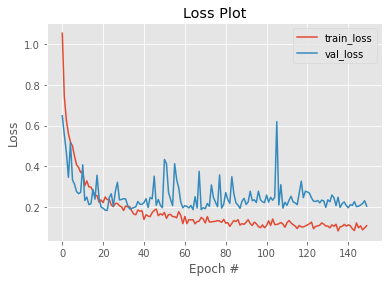

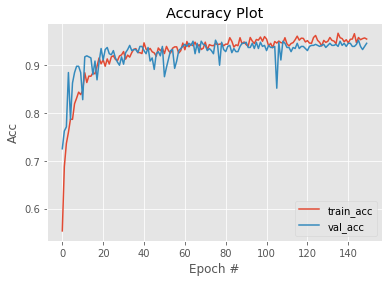

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 150), H1.history["loss"], label="train_loss")
plt.plot(np.arange(0, 150), H1.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 150), H1.history["acc"], label="train_acc")
plt.plot(np.arange(0, 150), H1.history["val_acc"], label="val_acc")
plt.title("Accuracy Plot")
plt.xlabel("Epoch #")
plt.ylabel("Acc")
plt.legend()

plt.show()

In [ ]:
ypred = model1.predict(test_generator)
predictions = np.argmax(ypred, axis = 1)
print(classification_report(test_generator.classes,predictions))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89       107
           1       0.95      0.95      0.95       215
           2       0.98      0.99      0.98       140

    accuracy                           0.95       462
   macro avg       0.94      0.94      0.94       462
weighted avg       0.95      0.95      0.95       462



In [ ]:
model1.save('/content/drive/MyDrive/MOD5IN/VGG19.tflite')
model1.save('/content/drive/MyDrive/MOD5IN/VGG19.h5')
model1.save('/content/drive/MyDrive/MOD5IN/VGG19.json')


INFO:tensorflow:Assets written to: /content/drive/MyDrive/MOD5IN/VGG19.tflite/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/MOD5IN/VGG19.json/assets


**Model 2**

**Evaluasi**
1 #Meningioma
2 #Pituitary
3 #Glioma

In [ ]:
MODEL_PATH = '/content/drive/MyDrive/MOD5IN/VGG19.h5'
model1 = load_model(MODEL_PATH,compile=False)

MODEL_PATH_2 = '/content/drive/My Drive/MOD5IN/EfficientNetB0.h5'
model2 = load_model(MODEL_PATH_2,compile=False)

In [ ]:
file_test_MENINGIOMA = os.path.join('/content/drive/MyDrive/MOD5IN/val/1')
file_test_PITUITARY = os.path.join('/content/drive/MyDrive/MOD5IN/val/2')
file_test_GLIOMA = os.path.join('/content/drive/MyDrive/MOD5IN/val/3')

MENINGIOMA_image = os.listdir(file_test_MENINGIOMA)
PITUITARY_image = os.listdir(file_test_PITUITARY)
GLIOMA_image = os.listdir(file_test_GLIOMA)

fname1 = [os.path.join(file_test_MENINGIOMA,fname)
        for fname in MENINGIOMA_image[0:5]]

fname2 = [os.path.join(file_test_PITUITARY,fname)
        for fname in PITUITARY_image[0:5]]

fname3 = [os.path.join(file_test_GLIOMA,fname)
        for fname in GLIOMA_image[0:5]]


In [ ]:
def preprocess(img,input_size):
    nimg = img.convert('RGB').resize(input_size, resample= 0)
    img_arr = (np.array(nimg))/255
    return img_arr

def reshape(imgs_arr):
    return np.stack(imgs_arr, axis=0)

labels = ['MENINGIOMA', 'PITUITARY', 'GLIOMA']
labels2 = ['MENINGIOMA', 'PITUITARY', 'GLIOMA']
labels3 = ['MENINGIOMA', 'PITUITARY', 'GLIOMA']
isian = [fname1, fname2, fname3]
input_size = (180, 180)

title = []
prediksi1 = []
prediksi2 = []
prediksi3 = []
waktu = []
akurasi1 = []
akurasi2 = []
akurasi3 = []

for x in list(range(len(labels))):
  for gambar in isian[x]:
    title.append(labels2[x])
    im = Image.open(gambar)
    X = preprocess(im, input_size)
    X = reshape([X])
    start = time.time()
    Y1 = model1.predict(X)
    Y2 = model2.predict(X)
    end = time.time()
    times = end-start
    prediksi1.append(labels[np.argmax(Y1)])
    prediksi2.append(labels[np.argmax(Y2)])
    waktu.append(times)
    akurasi1.append(np.max(Y1))
    akurasi2.append(np.max(Y2))

In [ ]:
import matplotlib.image as mping

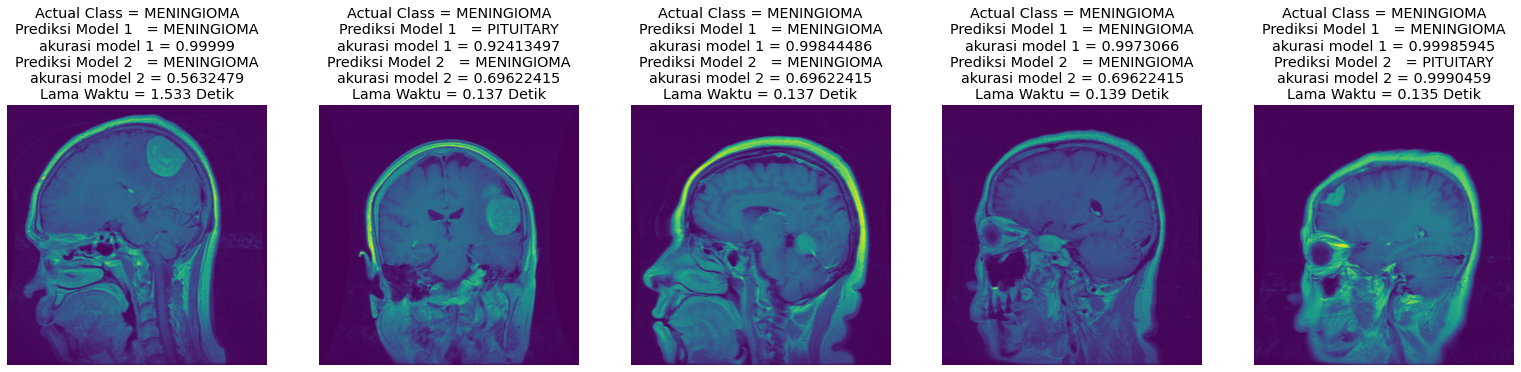

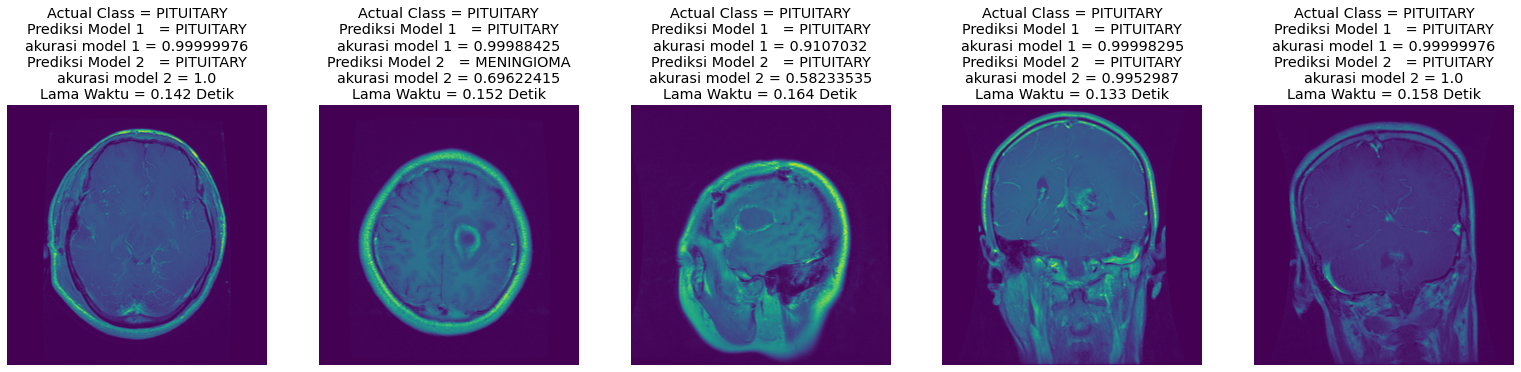

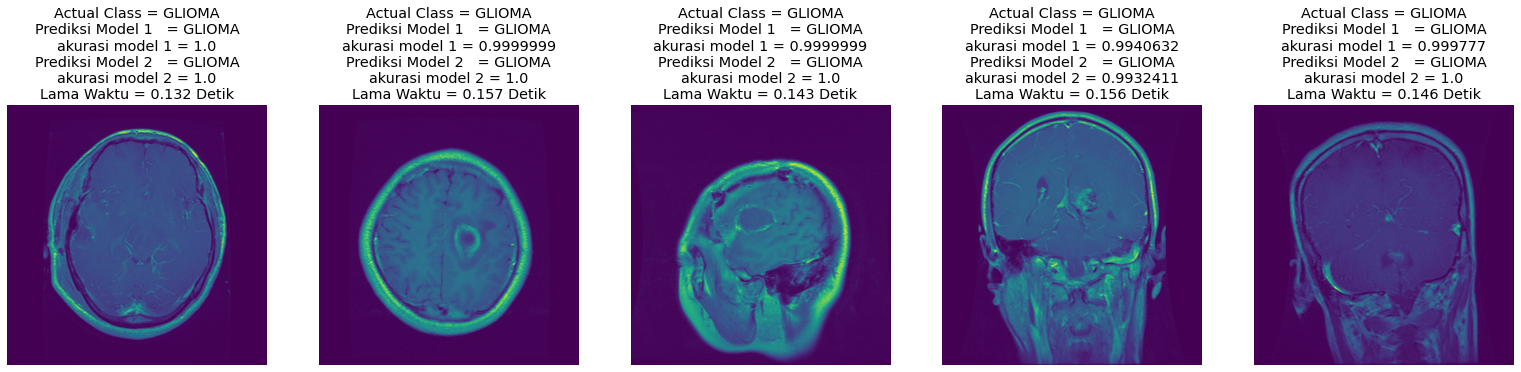

In [ ]:
xz = 0

ncolu = 3
nrow = 5
fig = plt.gcf()
fig.set_size_inches(ncolu*9,nrow*4)
for i,fname in enumerate(fname1):
    sp = plt.subplot(3,5,i+1)
    sp.axis('off')
    img = mping.imread(fname)
    judul = 'Actual Class = MENINGIOMA' + '\nPrediksi Model 1   = ' + prediksi1[xz] + '\nakurasi model 1 = '+ str(akurasi1[xz]) + '\nPrediksi Model 2   = ' + prediksi2[xz] + '\nakurasi model 2 = '+ str(akurasi2[xz]) +'\nLama Waktu = ' + '{:.3f}'.format(waktu[xz]) + ' Detik'
    xz = xz+1
    plt.title(judul)
    plt.imshow(img)
plt.show()

ncolu = 3
nrow = 5
fig = plt.gcf()
fig.set_size_inches(ncolu*9,nrow*4)
for i,fname in enumerate(fname2):
    sp = plt.subplot(3,5,i+1)
    sp.axis('off')
    img = mping.imread(fname)
    judul = 'Actual Class = PITUITARY' + '\nPrediksi Model 1   = ' + prediksi1[xz] + '\nakurasi model 1 = '+ str(akurasi1[xz]) +'\nPrediksi Model 2   = ' + prediksi2[xz] + '\nakurasi model 2 = '+ str(akurasi2[xz]) +'\nLama Waktu = ' + '{:.3f}'.format(waktu[xz]) + ' Detik'
    xz = xz+1
    plt.title(judul)
    plt.imshow(img)
plt.show()

ncolu = 3
nrow = 5
fig = plt.gcf()
fig.set_size_inches(ncolu*9,nrow*4)
for i,fname in enumerate(fname2):
    sp = plt.subplot(3,5,i+1)
    sp.axis('off')
    img = mping.imread(fname)
    judul = 'Actual Class = GLIOMA' + '\nPrediksi Model 1   = ' + prediksi1[xz] + '\nakurasi model 1 = '+ str(akurasi1[xz]) +'\nPrediksi Model 2   = ' + prediksi2[xz] + '\nakurasi model 2 = '+ str(akurasi2[xz]) +'\nLama Waktu = ' + '{:.3f}'.format(waktu[xz]) + ' Detik'
    xz = xz+1
    plt.title(judul)
    plt.imshow(img)
plt.show()
